##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 시계열 예측

이 튜토리얼에서는 TensorFlow를 사용한 시계열 예측을 소개합니다. Convolutional/Recurrent Neural Network(CNN 및 RNN)를 포함하여 몇 가지 다른 스타일의 모델을 빌드합니다.


- 단일 타임스텝 예측:
    - 단일 특성
    - 모든 특성
- 다중 스텝 예측:
    - 싱글샷: 모두 한 번에 예측합니다.
    - 자가 회귀: 한 번에 하나의 예측을 수행하고 결과를 모델로 피드백합니다.

## 설정

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2023-08-24 12:33:11.182808: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 12:33:11.223396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 12:33:11.840553: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 날씨 데이터세트

이 튜토리얼은 <a class="external" href="https://www.bgc-jena.mpg.de/wetter/">막스 플랑크 생물 지구화학 연구소</a>에서 기록한 <a class="external" href="https://www.bgc-jena.mpg.de">날씨 시계열 데이터세트</a>를 사용합니다.

이 dataset에는 온도, 대기압 및 습도와 같은 14가지 특성(feature)이 있습니다. 이러한 데이터는 2003년부터 시작해 **10분** 간격으로 수집되었습니다.

본 튜토리얼에서는 2009년과 2016년 사이에 수집된 데이터만 사용하겠습니다.

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [4]:
# pandas.read_csv: read a comma separated values (csv) file into DataFrame
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


이 튜토리얼은 **시간별 예측**만 다루므로 데이터를 1시간 간격으로 서브 샘플링하는 것으로 시작합니다.

우리 데이터는 **10분** 간격으로 수집되었고 python list의 index는 0부터 시작하므로, index 5부터 시작하여 6칸 간격으로 샘플링하면 됩니다.

In [5]:
# pandas.pop: return item and drop it from the frame

# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]
# Reformat 'Date Time' column
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

데이터를 살펴보겠습니다. 다음은 처음 몇 개의 행입니다.

In [6]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


시간이 지남에 따른 몇 가지 특성(feature)의 전개 양상은 다음과 같습니다.

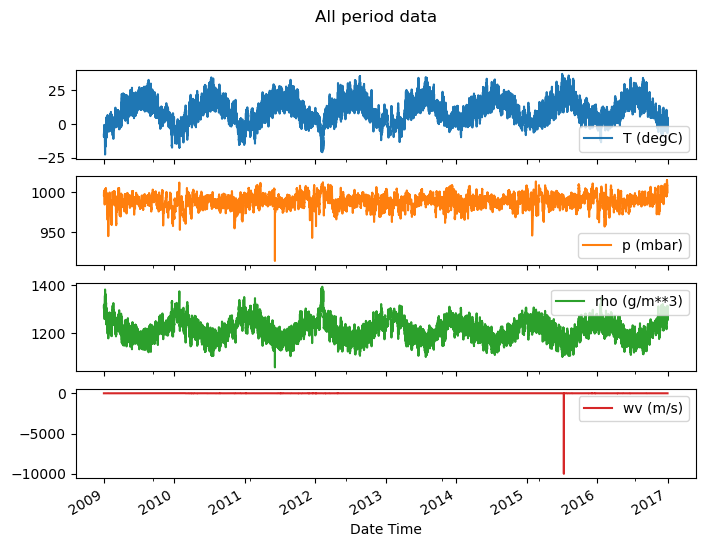

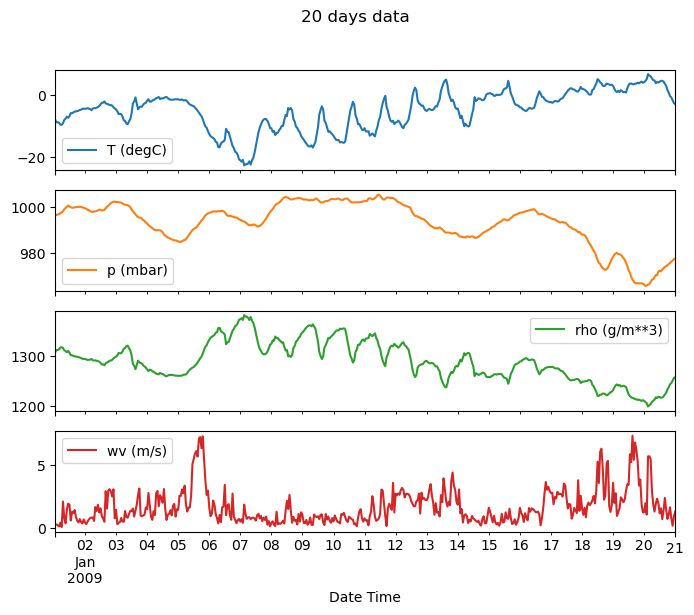

In [7]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)', 'wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, title="All period data")

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True, title="20 days data")

### 검사 및 정리하기

다음으로 데이터세트의 통계를 살펴봅니다.

In [8]:
# DataFrame.describe: generate descriptive statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### 풍속

한 가지 눈에 띄는 점은 풍속(`wv (m/s)`)의 `min` 값과 최댓값(`max. wv (m/s)`) 열입니다. `-9999`는 오류일 수 있습니다.

별도의 풍향 열이 있으므로 속도는 0보다 커야 합니다. 0미만의 값들을 0으로 교체합니다.

In [9]:
wv = df['wv (m/s)']
bad_wv = wv < 0.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv < 0.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

풍속 데이터의 분포를 다시 그려 보면, 에러 값들이 사라진 것을 알 수 있습니다.

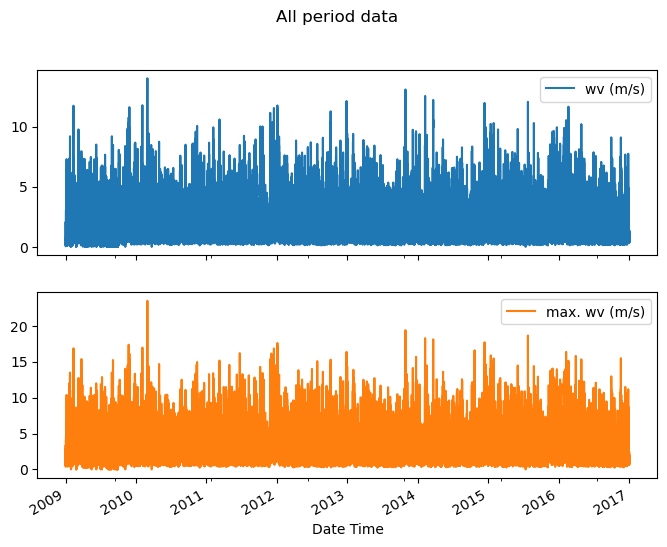

In [10]:
plot_cols = ['wv (m/s)', 'max. wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True, title="All period data")

### 특성 엔지니어링 (feature engineering)

모델을 구축하기 전에 데이터를 이해하고 모델에 적절한 형식의 데이터를 전달하고 있는지 확인하는 것이 중요합니다.

#### 바람

데이터의 마지막 열인 `wd (deg)` - 바람의 방향을 도 단위로 제공합니다. 각도는 좋은 모델 입력을 만들지 않습니다.

바람이 불지 않으면 방향은 중요하지 않습니다.

현재, 바람 데이터의 구성은 다음과 같습니다.


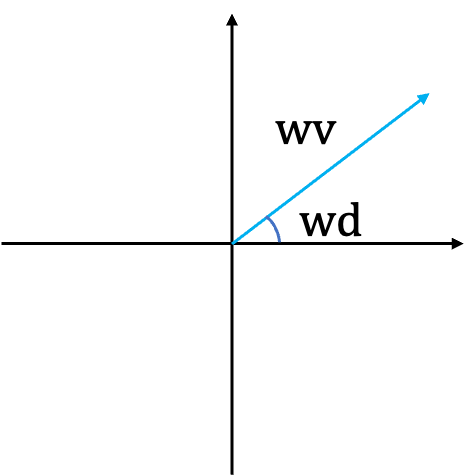

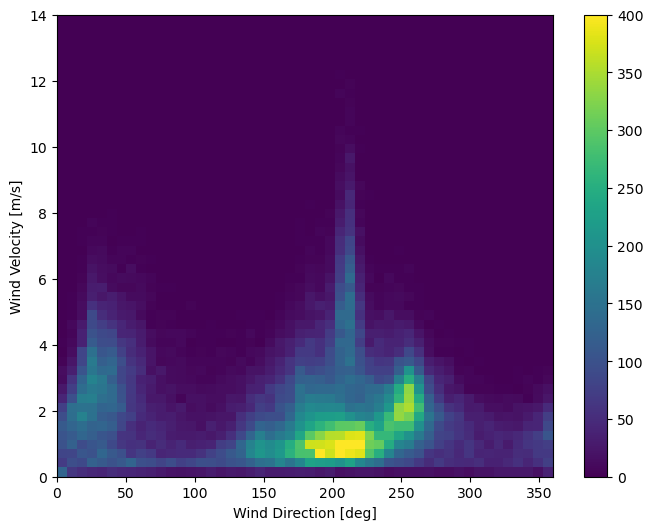

In [11]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.show()

그러나 풍향과 속도 column을 바람 **벡터**로 변환하면 모델이 해석하기가 더 쉽습니다.

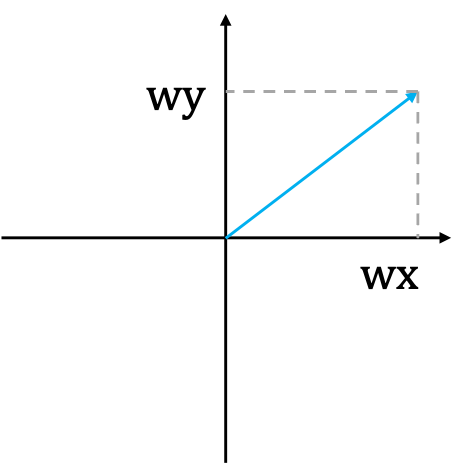

바람 벡터의 분포는 모델이 학습하기에 더 용이합니다.

In [12]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

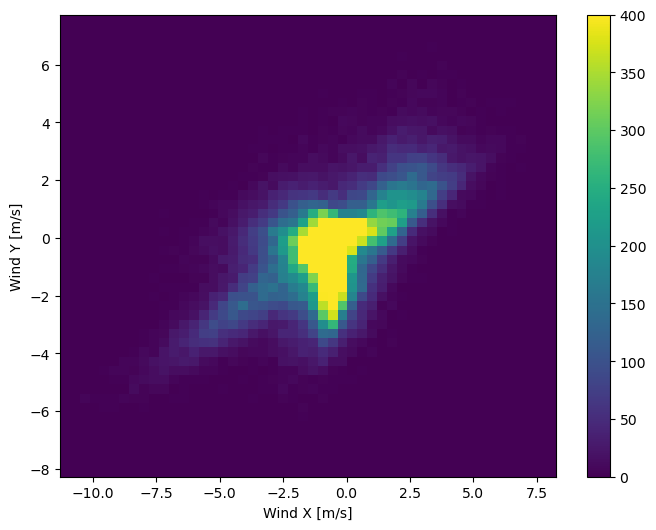

In [13]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
plt.show()

#### 시간

마찬가지로 `Date Time` 열은 매우 유용하지만 이 문자열 형식은 아닙니다. 우선 초 단위의 숫자로 변환합니다.

In [14]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

풍향과 유사하게 초 단위의 시간은 유용한 모델 입력이 아닙니다.
날씨 데이터이기 때문에 일별 및 연간 주기가 명확합니다. 주기성을 다룰 수 있는 방법은 여러 가지가 있습니다.

사인 및 코사인 변환을 사용하여 "시간" 신호를 지우면 사용 가능한 신호를 얻을 수 있습니다.

In [15]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

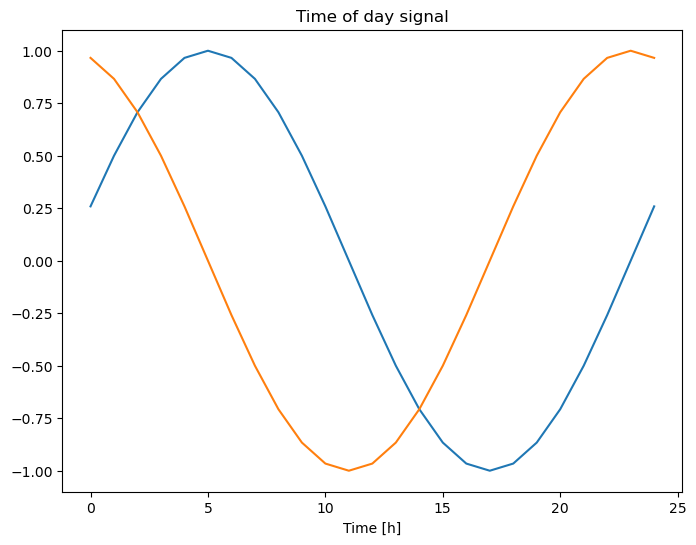

In [16]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')
plt.show()

그러면 모델이 가장 중요한 빈도 특성에 액세스할 수 있습니다. 이번 dataset의 경우, 특정 시간 단위로 측정했다는 사실을 알고 있었기 때문에 위와 같은 변환을 적용할 수 있었습니다.

해당 정보가 없는 경우 <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">고속 푸리에 변환</a>을 사용하여 특성을 추출하여 중요한 빈도를 결정할 수 있습니다.

예를 들어, `tf.signal.rfft`함수를 활용할 수 있습니다.

확인하기 위해 시간 경과에 따른 온도 데이터에 FFT를 적용하면 `1/year` 및 `1/day`에 가까운 빈도에서 명백한 피크가 있다는 점에 주목하세요.

\*주기 T, frequency f에 대해 T=1/f

2023-08-24 12:33:16.804781: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


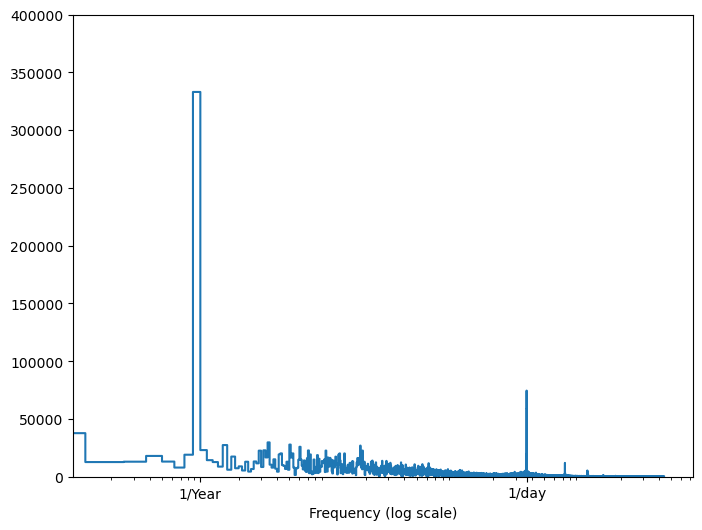

In [17]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### 데이터 분할

훈련(train), 검증(validation) 및 테스트(test) 세트에 `(70%, 20%, 10%)` 분할을 사용합니다.

1. 데이터를 연속된 샘플의 창(window)으로 자르는 것이 여전히 가능합니다.
2. 모델을 훈련한 후 수집된 데이터를 바탕으로 평가하므로 검증/테스트 결과가 보다 현실적입니다.

In [18]:
# dictionary
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(column_indices)
print(num_features)

{'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'Wx': 11, 'Wy': 12, 'max Wx': 13, 'max Wy': 14, 'Day sin': 15, 'Day cos': 16, 'Year sin': 17, 'Year cos': 18}
19


In [19]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917


In [20]:
test_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
378491,1001.93,2.80,275.81,1.25,89.5,7.47,6.69,0.78,4.16,6.68,1261.61,2.674455,1.336933,3.908819,1.953979,-8.660254e-01,0.500000,0.937670,0.347527
378497,1002.38,2.75,275.72,0.67,86.1,7.45,6.41,1.04,3.99,6.40,1262.54,2.836975,0.944286,4.943357,1.645394,-7.071068e-01,0.707107,0.937919,0.346855
378503,1002.63,2.46,275.41,0.46,86.6,7.29,6.32,0.98,3.93,6.30,1264.24,2.748864,1.298208,3.553630,1.678276,-5.000000e-01,0.866025,0.938167,0.346183
378509,1002.48,1.93,274.90,0.82,92.3,7.03,6.48,0.54,4.03,6.47,1266.37,1.506908,1.919070,2.352999,2.996580,-2.588190e-01,0.965926,0.938415,0.345510
378515,1002.42,1.87,274.84,0.76,92.3,6.99,6.45,0.54,4.01,6.44,1266.63,3.037622,1.614452,4.565263,2.426371,-1.801868e-12,1.000000,0.938662,0.344837


### 데이터 정규화

신경망을 훈련하기 전에 feature의 크기를 조절하는 것이 중요합니다.

**정규화**는 평균을 빼고 각 특성의 표준 편차로 나누어 크기 조정을 수행하는 일반적인 방법입니다.

- `Z = (X-m)/s`

모델이 검증 및 test set의 값에 액세스할 수 없도록 train data를 사용해서만 평균 및 표준 편차를 계산해야 합니다.


일반적으로는 모델이 훈련할 때, '미래' 값에 액세스할 수 없기 때문에 이동 평균(moving average)을 사용하여 평균 및 표준 편차를 계산해야 합니다.

이 내용은 본 튜토리얼의 중점 사항이 아니며, 검증 및 테스트 세트가 있기 때문에 (다소) 정직한 메트릭을 얻을 수 있습니다.

따라서 단순화를 위해 이 튜토리얼에서는 단순 평균을 사용합니다.

In [21]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
# note that we don't calculate val_mean/test_mean/...
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [22]:
train_df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366111,1.366069,-0.061052,1.428434
11,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707200,1.224794,-0.060029,1.428424
17,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000100,1.000059,-0.059006,1.428412
23,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224850,0.707179,-0.057983,1.428400
29,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366133,0.366112,-0.056960,1.428388


이제 특성의 분포를 살펴봅니다. 일부 특성은 꼬리가 길지만 `-9999` 풍속 값과 같은 명백한 오류는 없습니다.

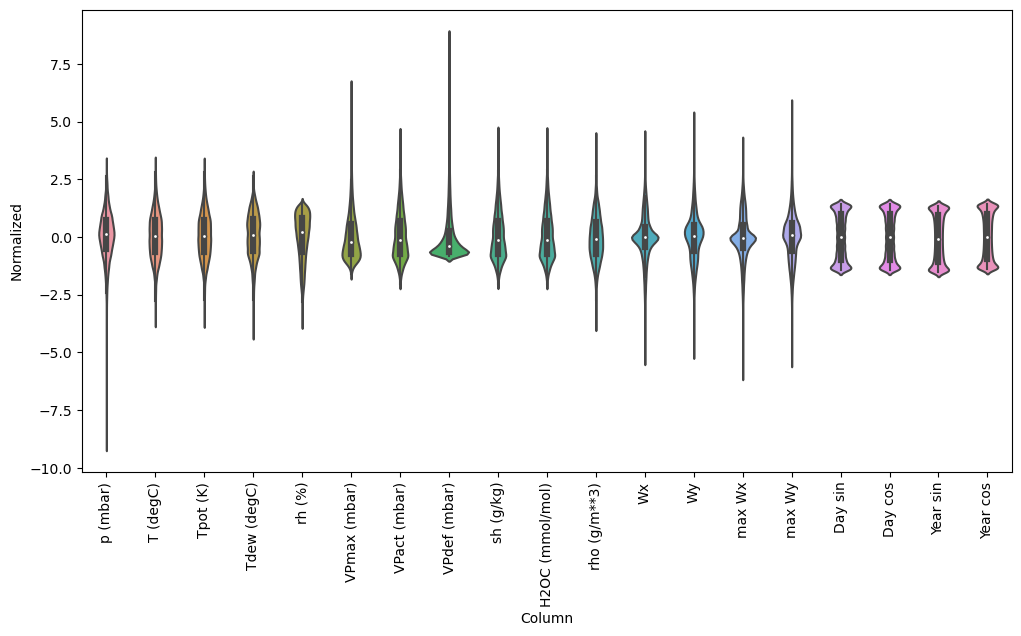

In [23]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Time series data 학습하기
우리는 수집한 과거~현재의 데이터로부터, 미래의 값을 예측하기를 원합니다.

다양한 방식이 가능합니다.
- 한 지점의 데이터를 입력해서, 바로 다음 순간의 값 예측하기
- 특정 구간의 데이터를 입력해서, 바로 다음 순간의 값 예측하기
- 특정 구간의 데이터를 입력해서, 다음 기간의 값 예측하기

일반적으로 데이터의 '특정 구간'을 창(window)으로 표현합니다.

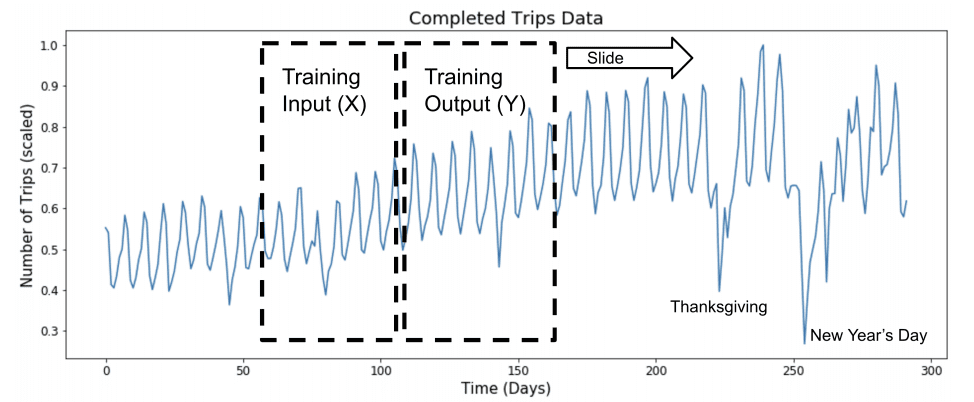

## 데이터 창(window) 작업

이 튜토리얼에서 학습시킬 모델들은, 데이터의 연속된 샘플 window를 기반으로 일련의 예측을 수행합니다.

입력 창(input window)을 설정할때 중요한 특징들은 다음과 같습니다. 

- 입력 및 레이블 창의 너비(타임스텝 수)
- 각 window 사이의 시간 오프셋
- 입력, 레이블 또는 둘 모두로 사용되는 feature

이 튜토리얼은 다양한 모델(선형, DNN, CNN 및 RNN 모델)을 학습하고 다음 두 가지 목적으로 이 모델을 사용합니다.

- *단일 출력* 및 *다중 출력* 예측
- *단일 타임스텝* 및 *다중 타임스텝* 예측

이 섹션에서는 모든 모델에 재사용할 수 있도록 데이터 창 생성 class를 구현합니다.


작업 및 모델 유형에 따라 다양한 데이터 창을 생성할 수 있습니다. 다음은 몇 가지 예입니다.

1. 24시간의 기록이 주어졌을 때 앞으로 24시간 후의 미래(48시간째)를 예측하기 위해 다음과 같은 window를 정의할 수 있습니다.

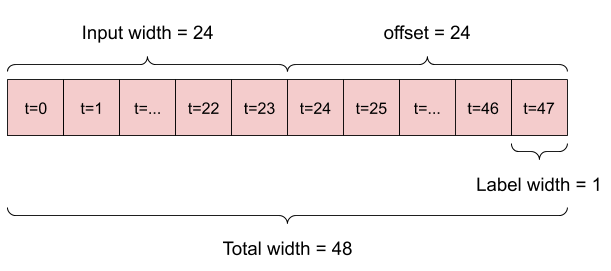


2. 6시간의 기록이 주어졌을 때 다음 1시간의 미래를 예측하는 모델에는 다음과 같은 window를 정의할 수 있습니다.


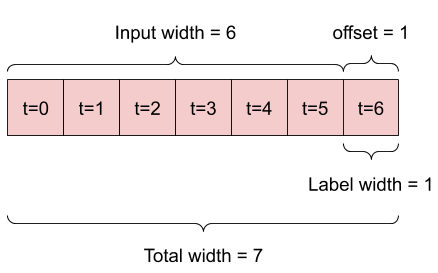

이 섹션의 나머지 부분에서는 `WindowGenerator` 클래스를 정의합니다. 이 클래스는 다음을 수행할 수 있습니다.

1. 위의 다이어그램과 같이 인덱스와 오프셋을 처리합니다.
2. 특성 window을 `(features, labels)` 쌍으로 분할합니다.
3. 결과 창의 내용을 플롯합니다.
4. `tf.data.Dataset`를 사용하여 훈련, 평가 및 테스트 데이터로부터 이러한 창(window)을 여러 배치(batch)로 효율적으로 생성합니다.

### 1. 인덱스 및 오프셋

우선 `WindowGenerator` 클래스를 만듭니다. `__init__` 메서드에는 입력 및 레이블 인덱스에 필요한 모든 logic이 포함됩니다.

또한 훈련(train), 평가(validation) 및 테스트(test) DataFrame을 입력으로 사용합니다. 이러한 DataFrame은 나중에 창의 `tf.data.Dataset`로 변환됩니다.

In [24]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    # slice: return a slice object (for indexing)
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

이 섹션의 시작 부분에서 다이어그램에 나타낸 두 개의 창을 만드는 코드는 다음과 같습니다.

In [25]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [26]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

`label_width`가 2 이상인 경우, 맨 오른쪽 끝 지점(`input_width + shift`번째 칸)을 기준으로 왼쪽으로 `label_width`만큼을 예측하고자 하는 window가 됩니다.

In [27]:
w3 = WindowGenerator(input_width=6, label_width=3, shift=3,
                     label_columns=['T (degC)'])
w3

Total window size: 9
Input indices: [0 1 2 3 4 5]
Label indices: [6 7 8]
Label column name(s): ['T (degC)']

In [28]:
w3 = WindowGenerator(input_width=6, label_width=3, shift=5,
                     label_columns=['T (degC)'])
w3

Total window size: 11
Input indices: [0 1 2 3 4 5]
Label indices: [ 8  9 10]
Label column name(s): ['T (degC)']

```
Total window size: 18
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Label indices: [15 16 17]
Label column name(s): ['T (degC)']
```
위와 같은 구성을 가지는 window를 생성하려면, 인자로 어떤 값들을 넣어줘야 할까요?

In [29]:
w3 = WindowGenerator(input_width=13, label_width=3, shift=5,
                     label_columns=['T (degC)'])
w3

Total window size: 18
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Label indices: [15 16 17]
Label column name(s): ['T (degC)']

### 2. 분할

연속적인 input 목록이 주어지면 `split_window` 메서드는 이 목록을 input 창과 label 창으로 변환합니다.

위에서 정의한 예제 `w2`는 다음과 같이 분할됩니다.

input window에 해당하는 데이터는 모델에 입력되는 데이터가 되고,
label window에 해당하는 데이터는 모델이 예측해야 하는 target 데이터가 됩니다.

이 다이어그램에는 데이터의 `features` 축이 나와 있지 않지만 이 `split_window` 함수는 단일 출력과 다중 출력 예에서 모두 사용될 수 있도록 `label_columns`를 처리합니다.

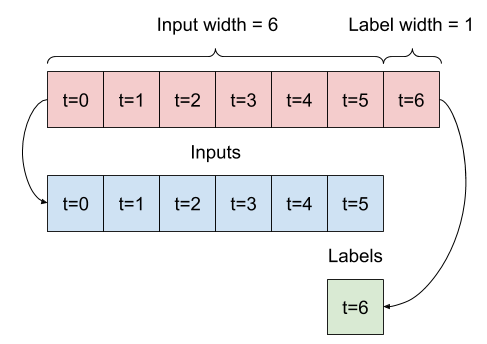

In [30]:
# features: batch * time * features
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [31]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])
example_inputs, example_labels = w2.split_window(example_window)

print(w2)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']
All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


일반적으로 TensorFlow의 데이터는 가장 바깥 쪽(첫번째 차원) 인덱스가 여러 예제("batch")에 걸쳐 있는 배열로 구성됩니다. 중간 인덱스는 "시간" 또는 "공간"(너비, 높이) 차원입니다. 가장 안쪽 인덱스는 특성입니다.

위의 코드는 3개의  7-타임스텝 window batch를 사용하며 각 타임스텝에는 19개의 feature가 있습니다. ([3, 7, 19])

그러면 이것을 한 batch 당 6-타임스텝과 19개의 특성 입력 및 1-타임스텝 1-특성 레이블로 분할합니다.

레이블에는 하나의 특성만 있는데 이는 `WindowGenerator`가 `label_columns=['T (degC)']`로 초기화되었기 때문입니다. 우선 이 튜토리얼에서는 단일 출력 레이블을 예측하는 모델을 빌드합니다.

### 3. 플롯하기

다음은 분할 창을 간단하게 시각화할 수 있는 플롯 메서드입니다.

In [32]:
w2.example = example_inputs, example_labels

In [33]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

이 플롯은 항목이 참조하는 시간을 기준으로 입력, 레이블 및 예측값을 정렬합니다.

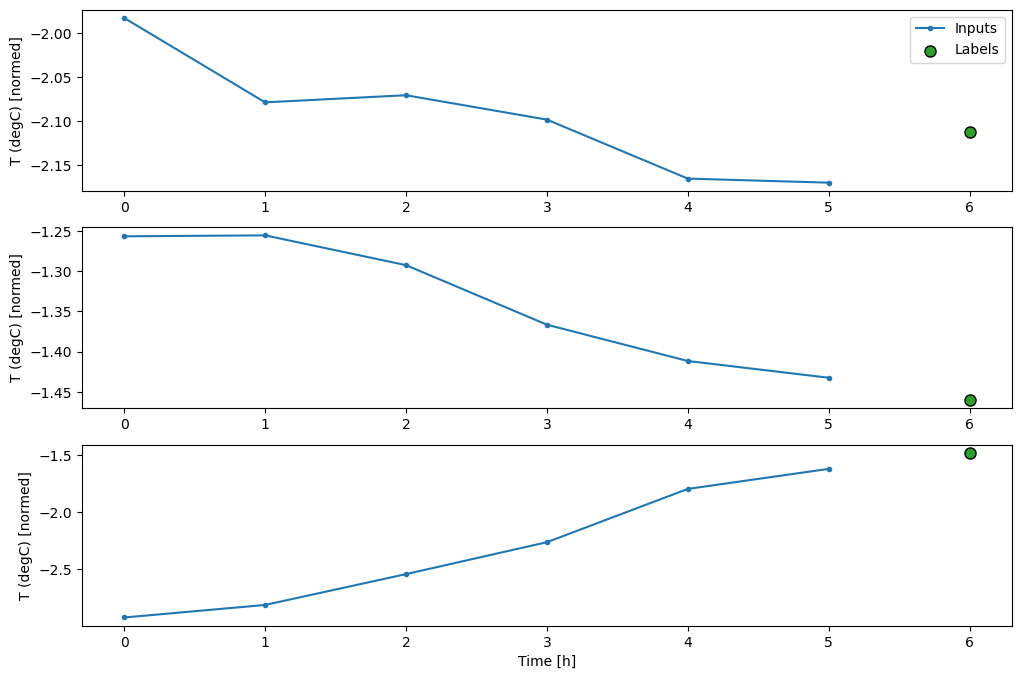

In [34]:
w2.plot()

다른 열을 플롯할 수 있지만 예제 창 `w2` 구성에는 `T (degC)` 열에 대한 레이블만 있습니다.

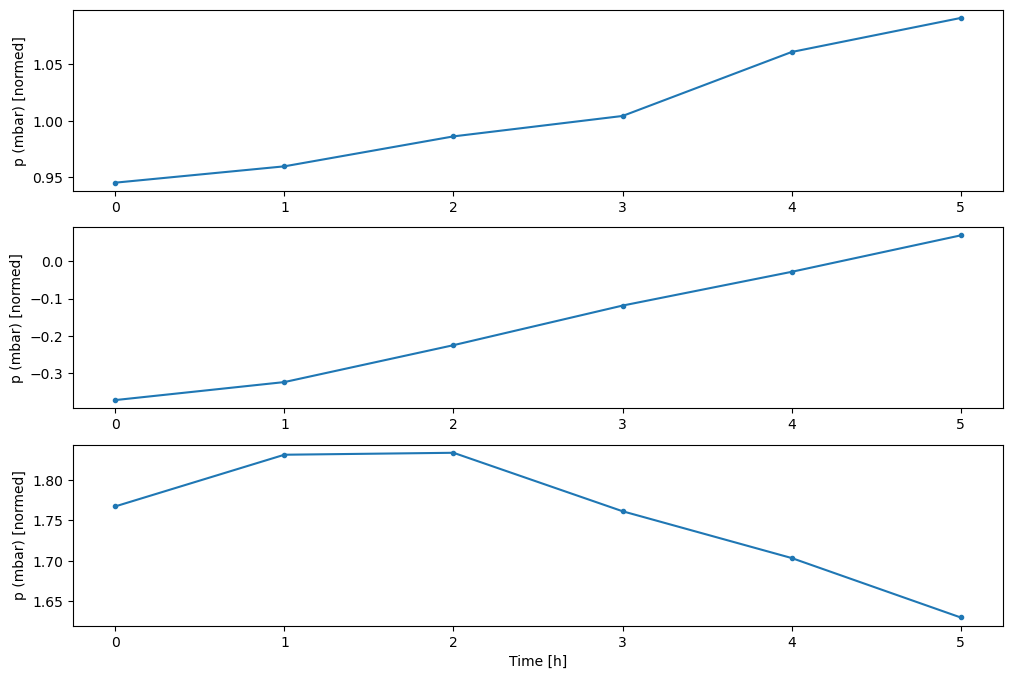

In [35]:
w2.plot(plot_col='p (mbar)')

### 4. `tf.data.Dataset` 만들기

마지막으로, 이 `make_dataset` 메서드는 시계열 DataFrame을 가져와 `tf.keras.utils.timeseries_dataset_from_array` 함수를 이용해 `(input_window, label_window)` 쌍의 `tf.data.Dataset`로 변환합니다.

In [36]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` 객체는 훈련, 검증, 테스트 데이터를 보존합니다.

앞에서 정의한 `make_dataset` 메서드를 사용하여 `tf.data.Dataset`로 액세스하기 위한 속성을 추가합니다. 또한 쉽게 액세스하고 플로팅할 수 있도록 표준 예제 배치를 추가합니다.

In [37]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

이제 `WindowGenerator` 객체가 `tf.data.Dataset` 객체에 대한 액세스 권한을 부여하므로 데이터를 쉽게 반복할 수 있습니다.

`Dataset.element_spec` 속성은 데이터세트 요소의 구조, 데이터 유형, 형상을 알려줍니다.

In [38]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

`Dataset`에서 `take`할 때 마다 batch단위의 data가 샘플링됩니다.

In [39]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## 단일 스텝 모델

이러한 종류의 데이터를 기반으로 빌드할 수 있는 가장 간단한 모델은 현재 조건만을 기초로 1 타임스텝(1시간) 후의 단일 특성 값을 예측하는 모델입니다.

따라서 1시간 미래의 `T (degC)` 값을 예측하는 모델을 빌드하는 것으로 시작하겠습니다.

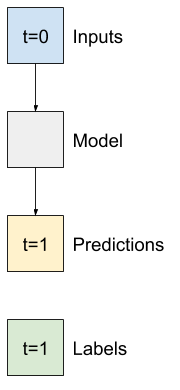

다음과 같은 단일 스텝 `(input, label)` 쌍을 생성하도록 `WindowGenerator` 객체를 구성합니다.

In [40]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

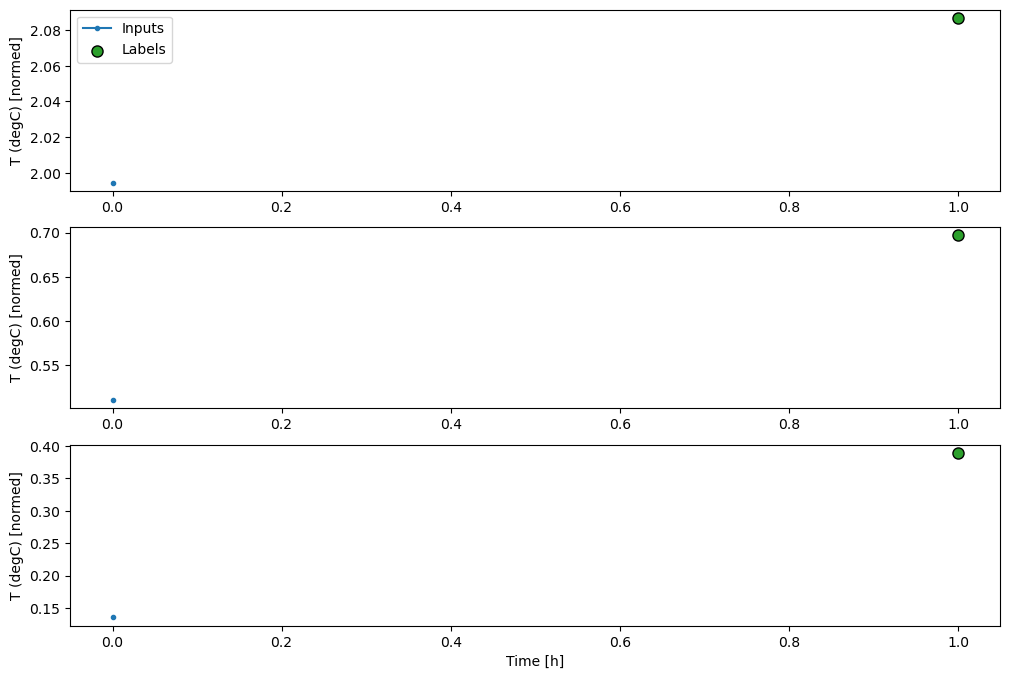

In [41]:
single_step_window.plot()

`window` 객체는 훈련, 검증 및 테스트 세트로부터 `tf.data.Datasets`를 생성하므로 데이터 배치를 쉽게 반복할 수 있습니다.


In [42]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


### 기준 (baseline)

훈련 가능한 모델을 빌드하기 전에 나중에 더 복잡한 모델과 비교하기 위한 포인트로 성능 baseline을 정의하는 것이 좋습니다.

첫 번째 작업은 모든 특성(19가지 feature)의 '현재 값'을 고려하여 '1시간 후'의 '온도'를 예측하는 것입니다. 현재 값에는 현재 온도가 포함됩니다.

따라서 예측 값으로 현재 온도를 반환하여 "변화 없음"을 예측하는 모델로 시작하겠습니다. 온도는 주로 천천히 변하기 때문에 나름 합리적인 기준이라고 할 수 있습니다.

물론, 더 예측을 더 많이 할 수록 이 baseline의 예측 성능은 떨어질 것입니다.


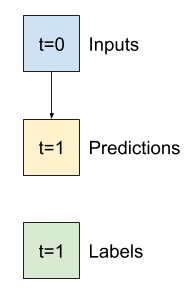

In [43]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

이 모델을 인스턴스화하고 평가합니다.

In [44]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 987us/step - loss: 0.0128 - mean_absolute_error: 0.0785


몇 가지 성능 메트릭을 출력했지만 모델이 얼마나 잘 동작하는지에 대한 감은 잘 오지 않습니다.

`WindowGenerator`에는 위에서 추가한 plot 메서드가 있지만 단일 샘플만으로는 플롯이 그다지 흥미롭지 않습니다.

따라서 한 번에 24시간 연속 입력 및 레이블 창을 생성하는 더 넓은 `WindowGenerator`를 만듭니다. 새로운 `wide_window`는 모델이 작동하는 방식을 변경하지 않습니다. 이 모델은 단일 입력 타임스텝을 기반으로 1시간 미래를을 예측합니다. 

각 예측은 타임스텝 사이의 상호 작용 없이 독립적으로 이루어집니다.

In [45]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

이 확장된 창은 어떠한 코드 변경 없이 동일한 `baseline` 모델에 직접 전달할 수 있습니다. 이는 입력과 레이블이 동일한 수의 타임스텝을 가지며 기준이 입력을 출력으로 전달하기 때문에 가능합니다.

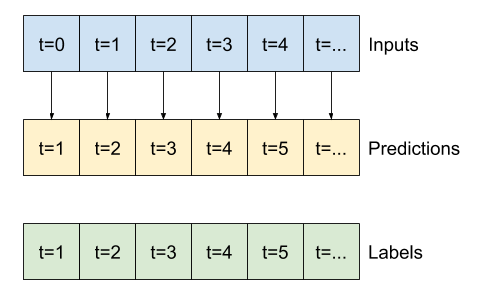

In [46]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


기준 모델의 예측을 플롯하면 1시간씩 오른쪽으로 이동한 단순한 레이블임을 알 수 있습니다.

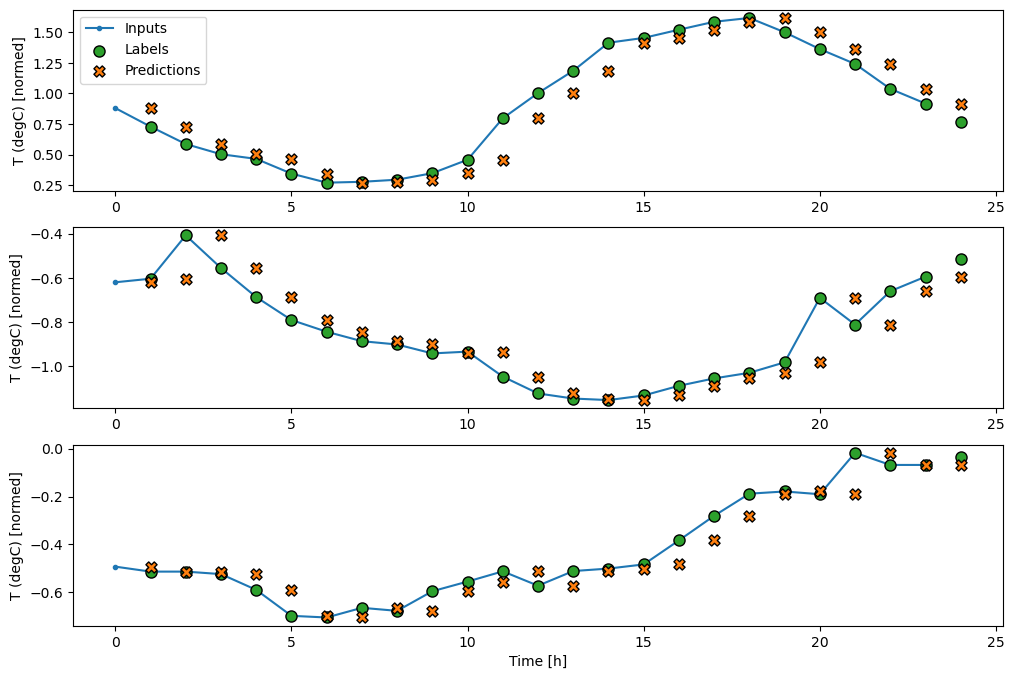

In [47]:
wide_window.plot(baseline)

위의 세 가지 예제 플롯에서 단일 스텝 모델은 24시간 동안 실행됩니다. 이에 관해 몇 가지 설명이 필요합니다.

- 파란색 `Inputs` 라인은 각 타임스텝의 입력 온도를 보여줍니다. 이 모델은 모든 특성을 수신하며 이 플롯은 온도만 표시합니다.
- 녹색 `Labels` 점은 목표 예측 값을 나타냅니다. 이러한 점은 입력 시간이 아니라 예측 시간에 표시됩니다. 레이벨의 범위가 입력에 상대적으로 한 스텝 이동하는 이유가 여기에 있습니다.
- 주황색 `Predictions` 십자는 각 출력 타임스텝에 대한 모델의 예측입니다. 모델이 완벽하게 예측하는 경우 예측은 `Labels` 바로 위에 놓여집니다.

### 선형 모델 (linear model)

이 작업에 적용할 수 있는 가장 간단한 **훈련 가능한** 모델은 입력과 출력 사이에 선형 변환을 삽입하는 것입니다. 이 경우 타임스텝의 출력은 해당 스텝에만 의존합니다.

선형 변환은 input feature x, weight matrix W, bias b에 대해 다음과 같이 정의됩니다.

- `x' = Wx + b`

`activation` 세트가 없는 `tf.keras.layers.Dense`는 선형 모델입니다. 레이어는 데이터의 마지막 축을 `(batch, time, inputs)`에서 `(batch, time, units)`로만 변환하며, `batch` 및 `time` 축의 모든 항목에 독립적으로 적용됩니다.

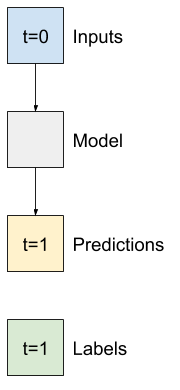

In [48]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [49]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


뒤에서 다른 모델을 훈련할 때도 활용할 수 있도록 훈련 절차를 하나의 함수로 만듭니다.

In [50]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

모델을 훈련하고 성능을 평가합니다.

In [51]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.2895 - mean_absolute_error: 0.3488 - val_loss: 0.0527 - val_mean_absolute_error: 0.1665
Epoch 2/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0248 - mean_absolute_error: 0.1136 - val_loss: 0.0115 - val_mean_absolute_error: 0.0792
Epoch 3/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0105 - mean_absolute_error: 0.0755 - val_loss: 0.0097 - val_mean_absolute_error: 0.0737
Epoch 4/20
1534/1534 [==============================] - 4s 2ms/step - loss: 0.0099 - mean_absolute_error: 0.0733 - val_loss: 0.0095 - val_mean_absolute_error: 0.0732
Epoch 5/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0098 - mean_absolute_error: 0.0726 - val_loss: 0.0095 - val_mean_absolute_error: 0.0733
Epoch 6/20
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0096 - mean_absolute_error: 0.0721 - val_loss: 0.0092 - val_mean_absolute_error: 0.0717
Epoc

`baseline` 모델과 마찬가지로 선형 모델은 넓은 범위의 배치에서 호출할 수 있습니다. 이러한 방식으로 모델은 연속적인 타임스텝에 대해 일련의 독립적인 예측을 수행합니다.

각 타임스텝에서 예측 사이에 상호 작용은 없습니다.


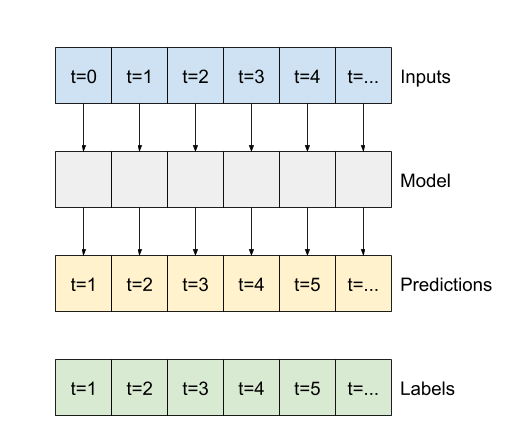

In [52]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


다음은 `wide_widow`에 대한 예제 예측을 플롯한 내용입니다. 많은 경우 예측이 단순히 입력 온도를 반환하는 것보다는 분명히 더 낫지만 몇 가지 경우에는 더 나쁘다는 사실에 주목하세요.

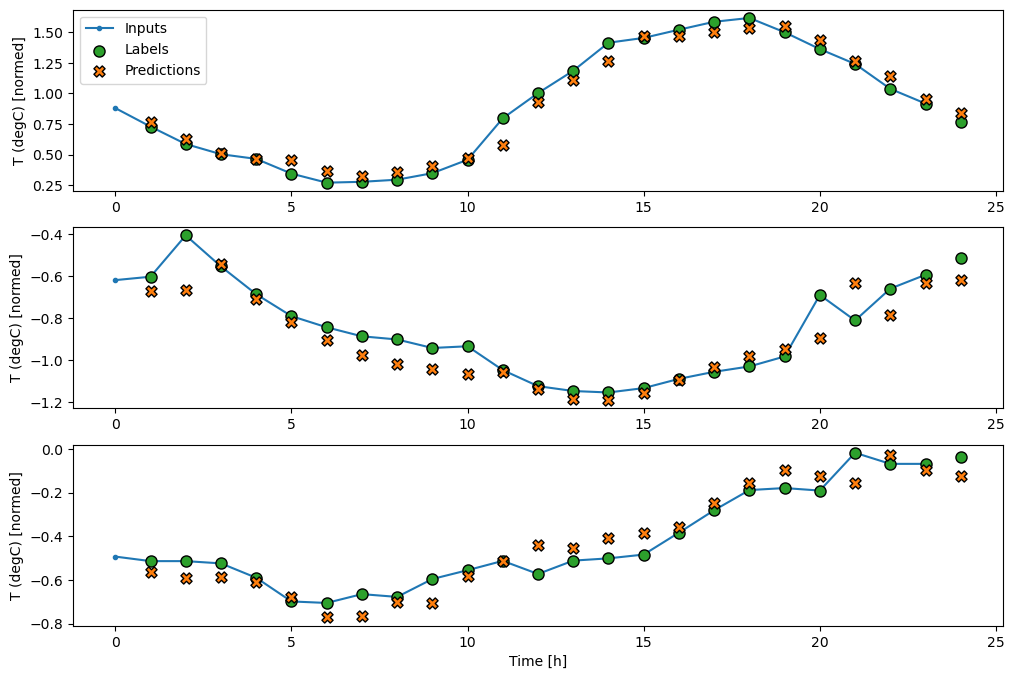

In [53]:
wide_window.plot(linear)

선형 모델의 한 가지 장점은 해석하기가 상대적으로 간단하다는 것입니다. 레이어의 가중치(W)를 가져와 각 입력에 할당된 가중치를 시각화할 수 있습니다.

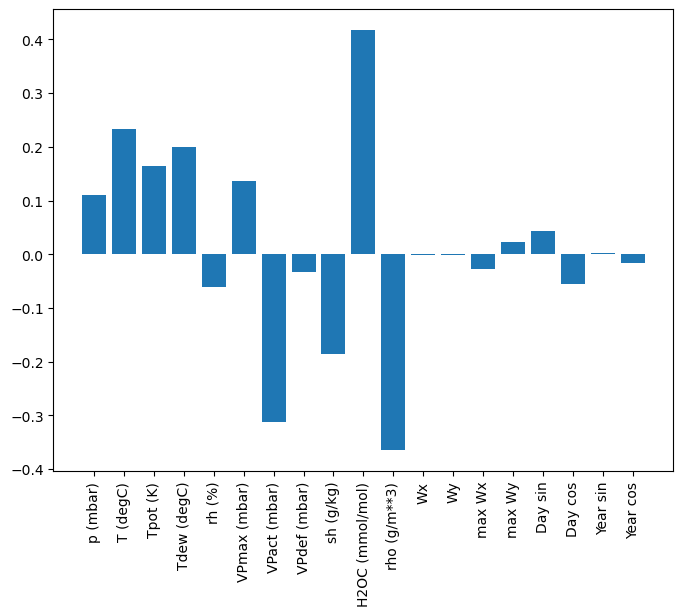

In [54]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

때로 모델은 입력 `T (degC)`에 가장 많은 가중치를 두지 않습니다. 이것은 무작위 초기화의 위험 중 하나입니다.

### 밀집 (Dense)

실제로 여러 타임스텝에서 동작하는 모델을 적용하기 전에 더 깊고 강력한 단일 입력 스텝 모델의 성능을 확인하는 것이 좋습니다.

다음 모델은 입력과 출력 사이에 몇 개의 `Dense` 레이어를 쌓는다는 점을 제외하면 `linear` 모델과 유사하지만, 모델의 용량(capacity)이 훨씬 크고, 더 좋은 성능을 보이리라 기대할 수 있습니다.

In [55]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0126 - mean_absolute_error: 0.0761 - val_loss: 0.0090 - val_mean_absolute_error: 0.0709
Epoch 2/20
1534/1534 [==============================] - 4s 3ms/step - loss: 0.0078 - mean_absolute_error: 0.0641 - val_loss: 0.0101 - val_mean_absolute_error: 0.0747
Epoch 3/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0074 - mean_absolute_error: 0.0621 - val_loss: 0.0078 - val_mean_absolute_error: 0.0649
Epoch 4/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0072 - mean_absolute_error: 0.0608 - val_loss: 0.0070 - val_mean_absolute_error: 0.0593
Epoch 5/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0071 - mean_absolute_error: 0.0600 - val_loss: 0.0068 - val_mean_absolute_error: 0.0584
Epoch 6/20
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0069 - mean_absolute_error: 0.0591 - val_loss: 0.0066 - val_mean_absolute_error: 0.0575
Epoc

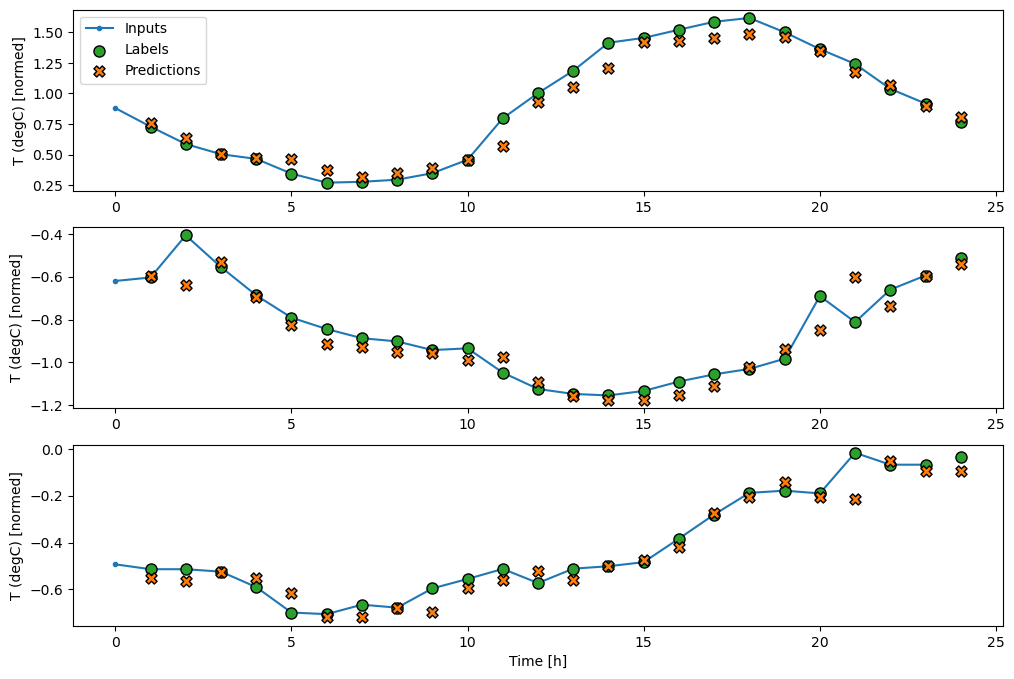

In [56]:
wide_window.plot(dense)

### 다중 스텝 밀집

단일 타임스텝 모델에는 입력의 현재 값에 대한 컨텍스트가 없습니다.

시간에 따라(특정 기간 동안) 입력 특성이 어떻게 변하는지 그 경향을 볼 수 없습니다.

이 문제를 해결하려면 모델이 예측을 수행할 때 여러 타임스텝에 액세스해야 합니다.



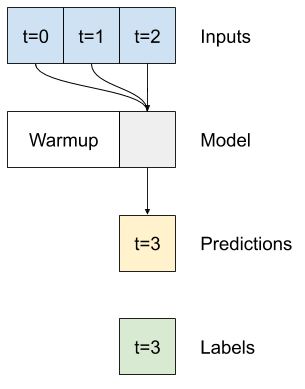

`baseline` , `linear` 및 `dense` 모델은 각 타임스텝을 독립적으로 처리했습니다. 여기서 모델은 단일 출력을 생성하기 위해 여러 타임스텝을 입력으로 사용합니다.

3시간의 입력과 1시간의 레이블 배치를 생성하는 `WindowGenerator`를 만듭니다.

In [57]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

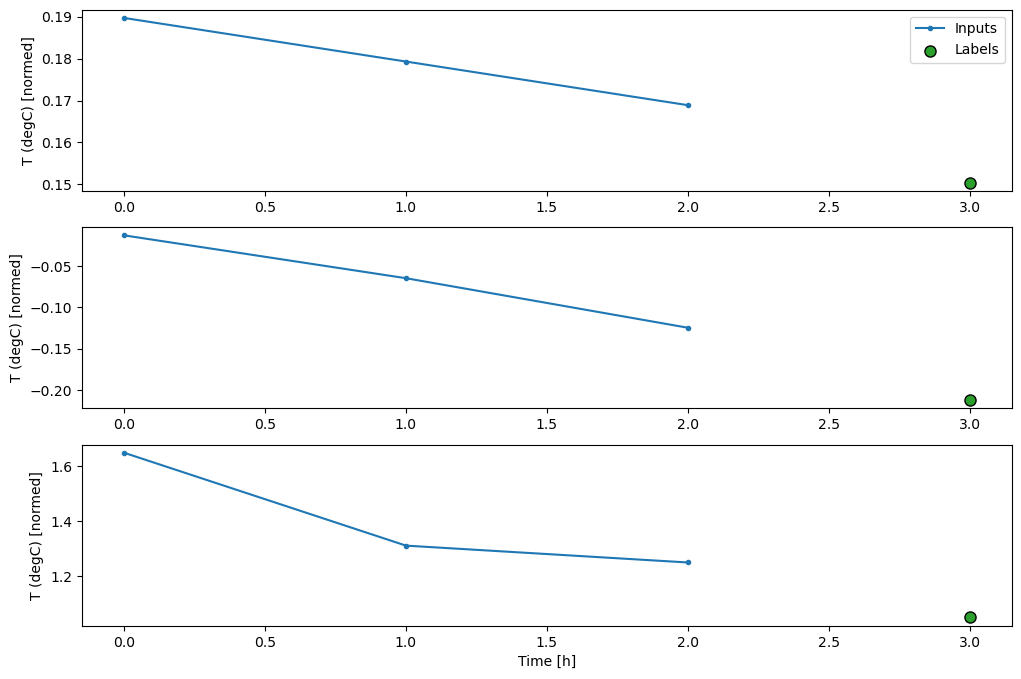

In [58]:
conv_window.plot()
plt.show()

`tf.keras.layers.Flatten`을 모델의 첫 번째 레이어로 추가하여 다중 입력 스텝 창에서 `dense` 모델을 훈련할 수 있습니다.

In [59]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [60]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [61]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 989us/step - loss: 0.0065 - mean_absolute_error: 0.0570


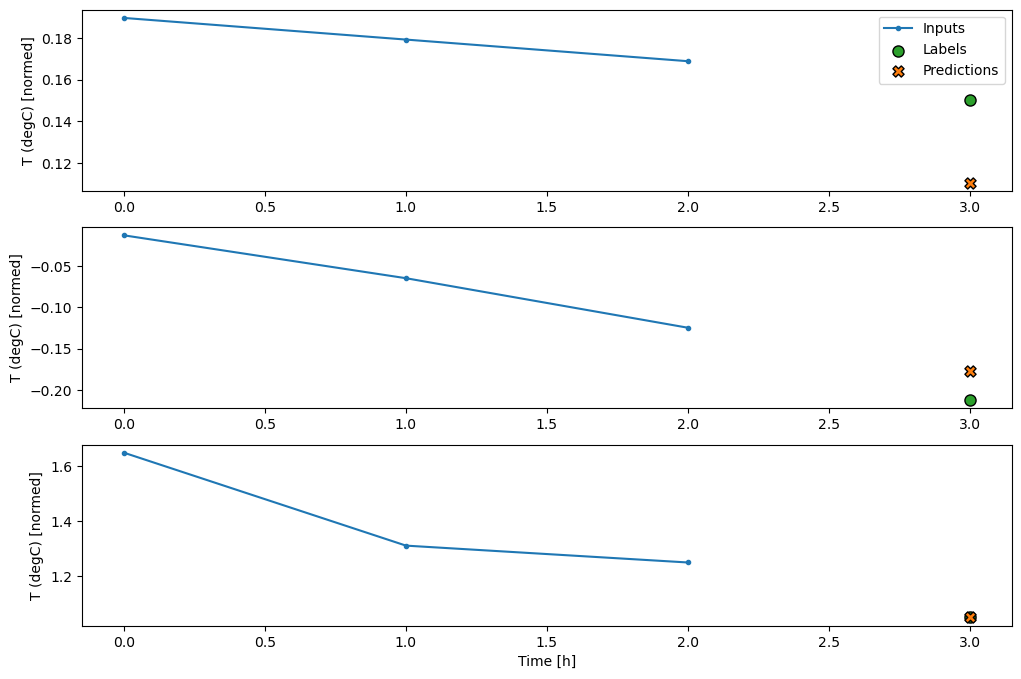

In [62]:
conv_window.plot(multi_step_dense)

이 접근법의 주된 단점은 결과적인 모델이 정확히 이 형상의 입력 창에서만 실행될 수 있다는 것입니다.

In [63]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer 'sequential_2' (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_2' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


첫 dense layer의 weight의 shape이, [3*19, batch_size]로 고정되어 있는 것을 확인할 수 있습니다.

In [64]:
multi_step_dense.layers[1].kernel.shape

TensorShape([57, 32])

다음 섹션의 컨볼루셔널 모델은 이 문제를 해결합니다.

### 컨볼루션 신경망

컨볼루션 레이어(`tf.keras.layers.Conv1D`)도 각 예측에 대한 입력으로 여러 타임스텝을 사용합니다.

다음은 컨볼루션으로 다시 작성한 `multi_step_dense`와 **동일한** 모델입니다.

다음 변경 사항에 주목하세요.

- `tf.keras.layers.Flatten`과 첫 번째 `tf.keras.layers.Dense`는 `tf.keras.layers.Conv1D`로 대체됩니다.
- 컨볼루션이 출력에서 시간 축을 유지하므로 `tf.keras.layers.Reshape`는 이 더 이상 필요하지 않습니다.

In [65]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

예제 배치에서 실행하여 모델이 예상한 형상으로 출력을 생성하는지 확인합니다.

In [66]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


`conv_window`에서 훈련하고 평가하면 `multi_step_dense` 모델과 유사한 성능을 제공해야 합니다.

In [67]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 2s 4ms/step - loss: 0.0064 - mean_absolute_error: 0.0571


이 `conv_model`과 `multi_step_dense` 모델의 차이점은 `conv_model`은 모든 길이의 입력에서 실행될 수 있다는 것입니다. 컨볼루셔널 레이어는 입력의 슬라이딩 창에 적용됩니다.

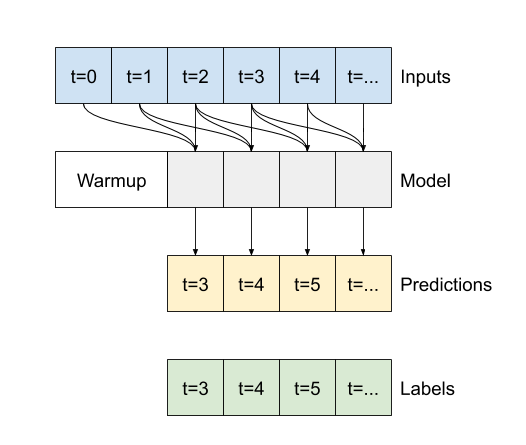

더 넓은 입력에서 실행하면 더 넓은 출력이 생성됩니다.

In [68]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


출력은 입력보다 짧습니다. 훈련 또는 플롯 작업을 수행하려면 레이블과 예상의 길이가 동일해야 합니다.

따라서 레이블과 예측 길이가 일치하도록 몇 개의 추가 입력 타임스텝으로 넓은 창을 생성하는 `WindowGenerator`를 빌드합니다.

In [69]:
LABEL_WIDTH = 24
# hint: use LABEL_WIDTH, CONV_WIDTH
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [70]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


이제 더 넓은 창에 모델의 예측을 플롯할 수 있습니다. 첫 번째 예측 전 3개의 입력 타임스텝에 주목하세요. 여기서 모든 예측은 이전 3개의 타임스텝에 기초합니다.

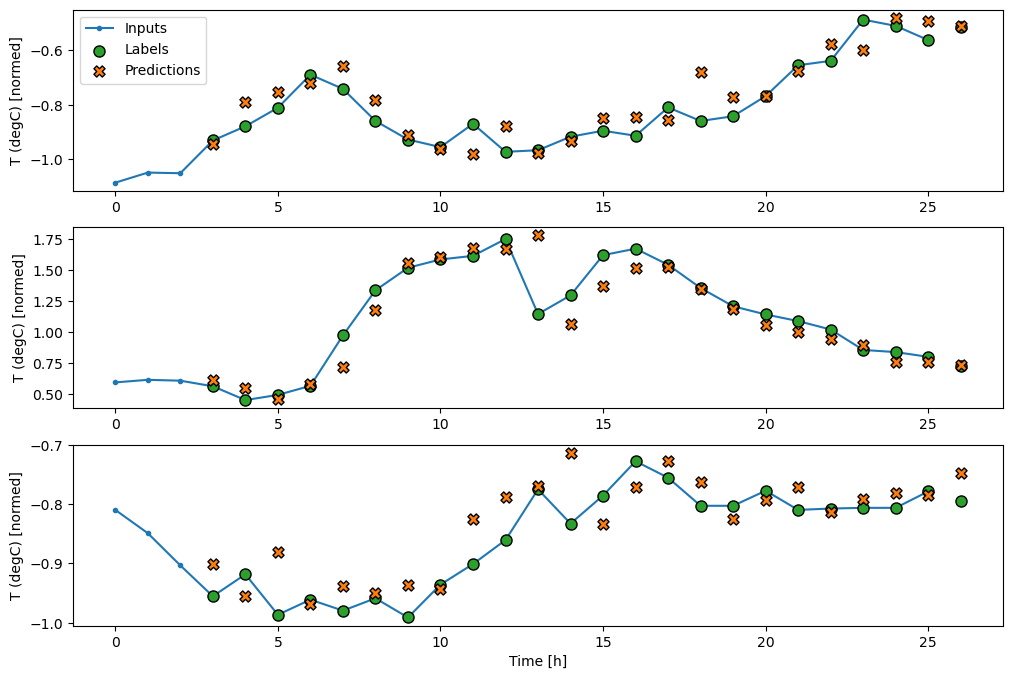

In [71]:
wide_conv_window.plot(conv_model)

### 순환 신경망

Recurrent Neural Network(RNN)는 시계열 데이터에 적합한 신경망 유형입니다. RNN은 시계열을 단계별로 처리하여 타임스텝 사이에서 내부 상태를 유지합니다.

[RNN을 사용한 텍스트 생성](https://www.tensorflow.org/text/tutorials/text_generation) 튜토리얼 및 [Keras를 사용한 순환 신경망(RNN)](https://www.tensorflow.org/guide/keras/rnn) 가이드에서 자세히 알아볼 수 있습니다.

이 튜토리얼에서는 LSTM(`tf.keras.layers.LSTM`)이라는 RNN 레이어를 사용합니다.

`tf.keras.layers.LSTM`와 같이 모든 keras RNN 레이어에 대한 중요한 생성자 인수는 `return_sequences` 인수입니다. 이 설정은 다음 두 가지 방법 중 하나로 레이어를 구성할 수 있습니다.

1. 기본값인 `False`인 경우 레이어는 최종 타임스텝의 출력만 반환하여 단일 예측을 수행하기 전에 모델이 내부 상태를 준비할 시간을 줍니다.

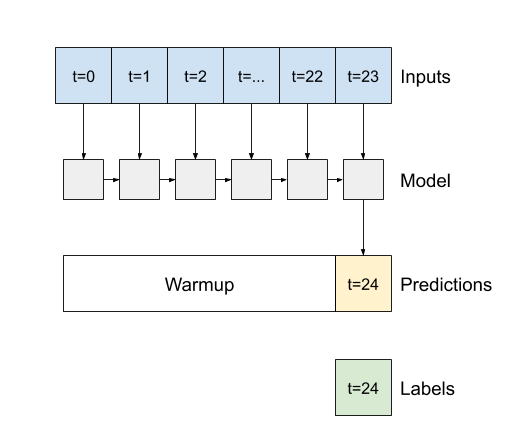

2. `True`이면 레이어가 각 입력에 대한 출력을 반환합니다. 다음과 같은 경우에 유용합니다.
    - RNN 레이어 스태킹
    - 여러 타임스텝에서 동시에 모델 훈련

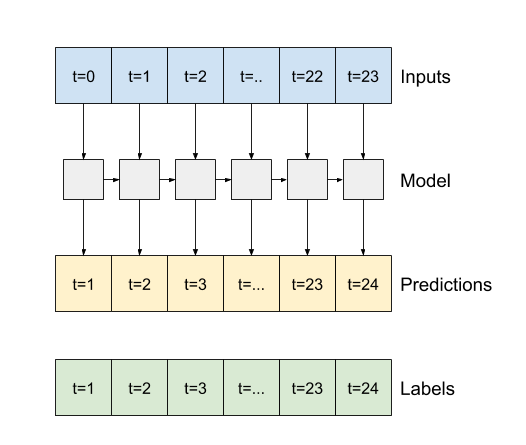

In [72]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

`return_sequences=True`이면 모델을 한 번에 24시간 분량 데이터에 대해 훈련할 수 있습니다.

참고: 이 경우에는 모델 성능의 관점에서 특별히 더 기대할 것이 없습니다.

첫 번째 타임스텝에서 모델이 이전 스텝에 액세스할 수 없으므로 이전에 표시한 단순한 `linear` 및 `dense` 모델보다 더 나을 것이 없기 때문입니다.

그럼에도, 전체 성능은 약간 더 좋은 편입니다.

In [73]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [74]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 4s 8ms/step - loss: 0.0055 - mean_absolute_error: 0.0513


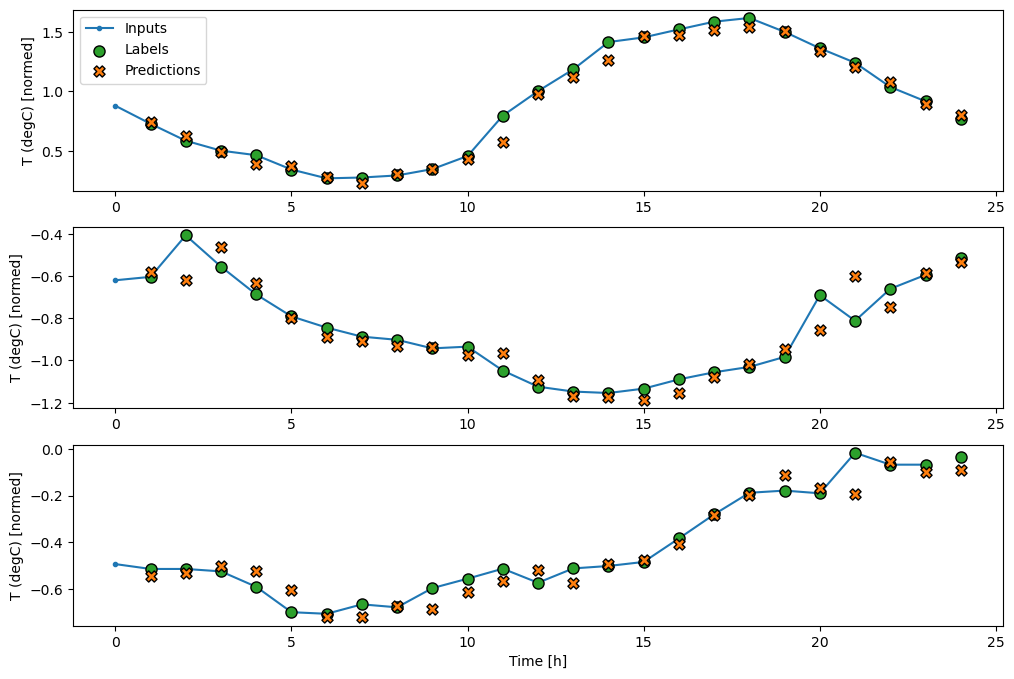

In [75]:
wide_window.plot(lstm_model)

### 성능

종합하면, 현재 사용 중인 dataset에 대해서는, 우리가 학습한 모델 유형들이 배운 순서대로 성능이 더 좋은 편입니다.

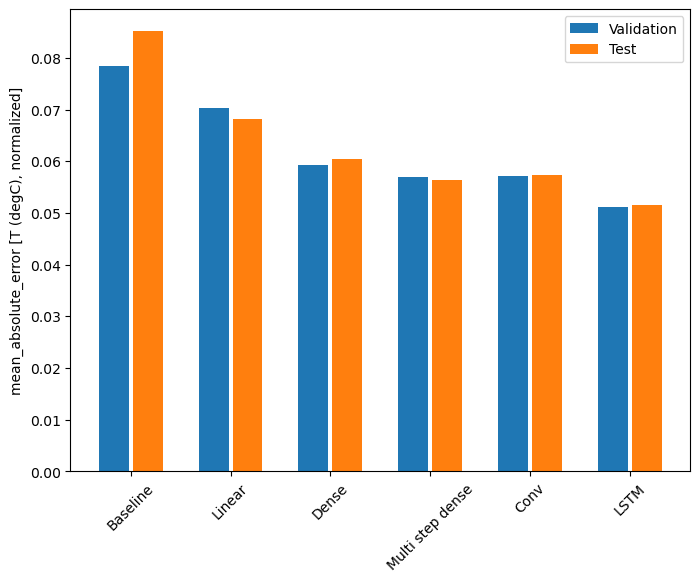

In [76]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [77]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0682
Dense       : 0.0604
Multi step dense: 0.0565
Conv        : 0.0574
LSTM        : 0.0515


### 다중 출력 모델

지금까지 모델은 모두 단일 타임스텝에 대해 단일 출력 특성 `T (degC)`를 예측했습니다.

이러한 모든 모델은 간단히 출력 레이어의 단위 수를 변경하고 labels(`example_labels`)에 모든 feature들을 포함하도록 훈련 window를 조정하여 여러 feature들을 예측하도록 변환할 수 있습니다.

In [78]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


레이블의 `features` 축은 이제 1이 아닌 입력과 동일한 깊이를 갖습니다.

#### 기준

여기서는 동일한 기준 모델(`Baseline`)을 사용할 수 있지만 이번에는 특정 `label_index`를 선택하는 대신 각각의 특성을 반복합니다.

In [79]:
baseline = Baseline()
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [80]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 914us/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense
dense layer 3개를 쌓고, 각 layer 사이의 activation은 relu를 사용하세요.
각 layer의 output 크기는 64 - 64 - num_features로 설정하세요.

In [81]:
# hint: use num_features
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [82]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.0693 - mean_absolute_error: 0.1312


#### RNN


In [83]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 4s 8ms/step - loss: 0.0616 - mean_absolute_error: 0.1200

CPU times: user 31min 28s, sys: 3min 45s, total: 35min 14s
Wall time: 7min 37s


<a id="residual"></a>

#### 고급: 잔여 연결

이전의 `Baseline` 모델은 시퀀스가 타임스텝 사이에서 '크게' 변하지 않는다는 사실을 이용했습니다.

지금까지 이 튜토리얼에서 훈련한 모든 모델은 무작위로 초기화된 다음, 출력이 이전 타임스텝에서 약간 변경된값을 예측하도록 학습되어야 했습니다.

신중한 초기화로 이 문제를 해결할 수 있지만 모델 구조의 변경을 통해 해결하는 것이 더 간단합니다.

시계열 분석에서는 '다음 값'을 예측하는 대신 다음 타임스텝에서 '값이 어떻게 달라지는 지'를 예측하는 모델을 빌드하는 것이 일반적입니다.

이런 상황에 딱 맞는 네트워크 구조로 딥러닝에서 사용하는 <a href="https://arxiv.org/abs/1512.03385" class="external">잔여 네트워크</a>(Residual networks; ResNet)가 있습니다.
ResNet은 각 레이어가 모델의 누적 결과에 추가되는 아키텍처를 가집니다. 이것은 변화가 작아야 한다는 사실을 이용하는 방법입니다.

기본적으로, `Baseline`과 일치하도록 모델을 초기화합니다. 그러면 이 작업에서 약간 더 나은 성능으로 모델이 더 빨리 수렴시키는 데 도움이 됩니다.


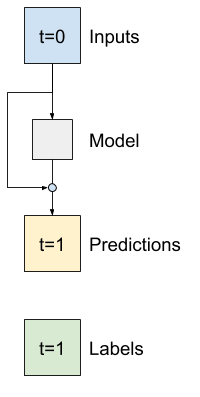

위 설명에 맞도록 `ResidualWrapper` 클래스의 `call` 함수를 구현하세요.

In [84]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

이 접근 방식은 이 튜토리얼에서 설명하는 모든 모델과 연계하여 사용할 수 있습니다.

여기서는 LSTM 모델에 적용합니다. `tf.initializers.zeros`를 사용하여 초기 예측하는 변경이 작고 잔류 연결을 압도하지 않도록 한다는 점에 유의하세요.

In [85]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 4s 8ms/step - loss: 0.0621 - mean_absolute_error: 0.1177

CPU times: user 14min 19s, sys: 1min 45s, total: 16min 4s
Wall time: 3min 30s


#### 성능

다음은 이러한 다중 출력 모델의 전반적인 성능입니다.

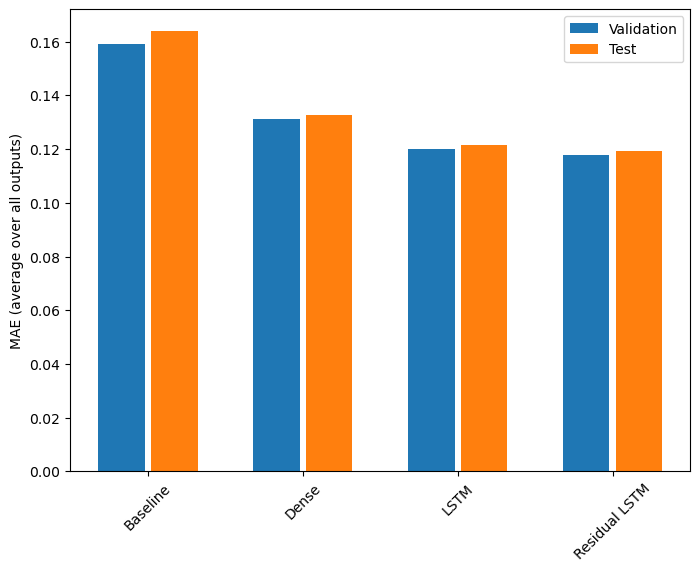

In [86]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [87]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1327
LSTM           : 0.1213
Residual LSTM  : 0.1193


위의 성능은 모든 모델 출력에 대한 평균입니다.